# Init

In [1]:
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from pathlib import Path
import json
%cd ..
%load_ext autoreload

c:\Users\kepes\Projects\segmentation


In [2]:
%autoreload 2
from src.MapData import MapData, min_max_dist, triangle_corr, get_triangular_kernel
from src.LineFinder import LineFinder

from src.plotting_functions import plot_embedding, plot_single_variable_map

# Data

In [3]:
map_data = MapData(            
    './data/2022_03_22_P56B_307x532.libsdata',
    overwrite=False
)
map_data.get_metadata()
map_data.load_wavelenths()
# map_data.load_all_data('preprocessed')
# map_data.spectra = map_data.spectra[:200,:]
map_data.get_map_dimensions()

map_data.trim_spectra(64)
map_data.wvl = map_data._upsample_wvl(map_data.wvl)

# map_data.estimate_systemic_noise()

# map_data.get_baseline(
#             min_window_size=50,
#             smooth_window_size=100
# )
# map_data.baseline_correct()

# map_data.upsample_spectra()
# map_data.denoise_spectra(
#             file_name_supplement='preprocessed',
#             threshold=np.std(map_data.systemic_noise_spectrum)
# )

map_data.spectra = np.load('./temp/P56B/preprocessed.npy')
map_data.wvl
maxima_spectrum = map_data.spectra.max(axis=0)

loading metadata
loading wavelengths
getting map dimensions


## Line finding

In [ ]:
line_finder = LineFinder(
    maxima_spectrum,
    map_data.wvl,
    name='maxima'
)
line_finder.find_lines(
    height=250,
    threshold=None,
    distance=None,
    prominence=250,
    width=3,
    wlen=27,
    rel_height=1.2,
)
line_finder.load_nist_tables(
    # Path('D:/OneDrive - Vysoké učení technické v Brně/projects/marsData/inventory/nistTables')
    Path('C:/Users/kepes/OneDrive - Vysoké učení technické v Brně/projects/marsData/inventory/nistTables')
)
line_finder.find_peaks_in_reference(
    maxima_spectrum, 
    scale=False,
    show_cond=False
)

In [ ]:
line_finder.plot

## Line intensities

In [ ]:
map_data.get_emission_line_intensities(
    line_finder.peaks[1].get('left_bases'),
    line_finder.peaks[1].get('right_bases'),
    line_centers=line_finder.peaks[0],
    intensity_funcs=[np.max,np.sum,min_max_dist,triangle_corr]
)

In [ ]:
for func in map_data.line_intensities:
    for line in map_data.line_intensities[func]:
        map_data.line_intensities[func][line] = map_data.line_intensities[func][line].tolist()

with open('./temp/P56B/lineIntensities.json','w') as file:
    json.dump(map_data.line_intensities,file)

In [4]:
with open('./temp/P56B/lineIntensities.json','r') as file:
    map_data.line_intensities = json.load(file)

for func in map_data.line_intensities:
    for line in map_data.line_intensities[func]:
        map_data.line_intensities[func][line] = np.array(map_data.line_intensities[func][line])

## Line ratios

In [ ]:
line_ratios = dict()
for func in map_data.line_intensities:
    line_ratios[func] = dict()
    for ref_line in map_data.line_intensities[func]:
        line_ratios[func][f'div_by_{ref_line}'] = {
            f'{line}/{ref_line}':np.divide(
                intensities,
                map_data.line_intensities.get(func).get(ref_line),
            )
            for line,intensities
            in map_data.line_intensities.get(func).items()
            if ref_line != line
        }

In [ ]:
for normalization_id in line_ratios:
    for line,intensities in line_ratios[normalization_id].items():
        file_name = "P56B/{}/line_max_{}_nm".format(
            normalization_id.replace('.','_'),
            line.replace('.','_').replace('/','by')
        )
        print(file_name)
        if not Path('./temp').joinpath(file_name).parent.exists():
            Path('./temp').joinpath(file_name).parent.mkdir(parents=True)
        plot_single_variable_map(
            plot_values=map_data.vector_to_array(intensities),
            file_id=file_name,
            figure_title=f'{line} nm',
            colorbar_title='Intensity',
            fig_size_scaling=3.,
            cutoff_quantile=.99
        )

        plt.close()

## Saving maps

In [ ]:
for intensity_func in map_data.line_intensities:
    for line,intensities in map_data.line_intensities[intensity_func].items():
        file_name = f"P56B/denoised/intensityMaps/{intensity_func}_{line.replace('.','_')}_nm"
        if not Path('./temp').joinpath(file_name).parent.exists():
            Path('./temp').joinpath(file_name).parent.mkdir(parents=True)
        print(file_name)
        plot_single_variable_map(
            plot_values=map_data.vector_to_array(intensities),
            file_id=file_name,
            figure_title=f'{line} nm',
            colorbar_title='Intensity',
            fig_size_scaling=3.,
            cutoff_quantile=.99
        )

        plt.close()

# Embeddings

In [7]:
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.manifold import TSNE

In [8]:
embeddings = dict()
embedders = dict()
embedders['pca'] = PCA(n_components=3)
embedders['tsne'] = TSNE(
    n_components=3,
    perplexity=30,
    learning_rate=200
)
embedders['umap'] = UMAP(
    n_components=3, 
    n_neighbors=30, 
    min_dist=0.5
)

In [10]:
for embedding_method in ['pca','tsne','umap']:
    try:
        embeddings[embedding_method] = np.load(f'./temp/embeddings_{embedding_method}.npy')
    except FileNotFoundError:
        print(f'embedding using {embedding_method} not found, creating...')
        embeddings[embedding_method] = embedders[embedding_method].fit_transform(
            pd.DataFrame(map_data.line_intensities)
        )

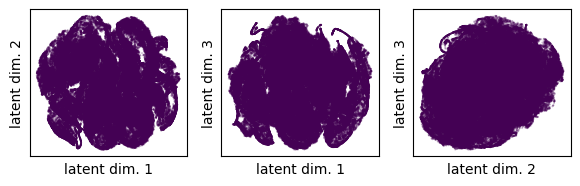

In [13]:
embedding_method = 'tsne'

fig = plot_embedding(
    embeddings[embedding_method],
    # explained_variances=pca_model.explained_variance_ratio_.copy(),
    # colors=predicted_labels[clustering_method],
    marker_size=2,
    return_figure=True
)
# fig.suptitle(clustering_method)
fig.patch.set_alpha(0)
fig.tight_layout()
# fig.savefig(
#     f'./temp/{embedding_method}_embeddings_full_spectra_clustering_using_{clustering_method}_{segment}',
#     transparent=True
# )

# from joblib import load
# pca_model = load('../temp/pca_model.joblib')

c:\Users\kepes\Projects\segmentation\src\plotting_functions.py:192: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


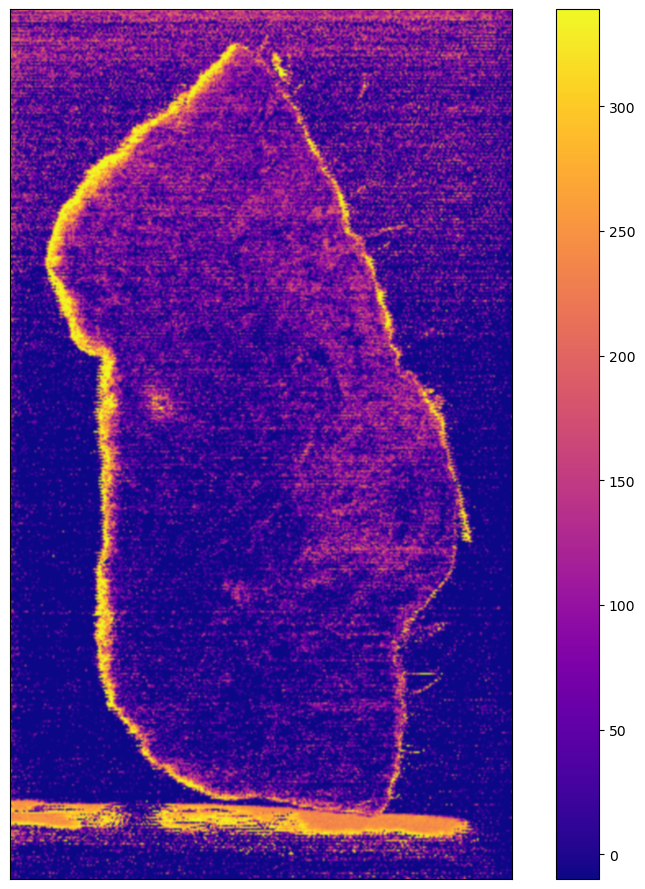

In [12]:
plot_data = map_data.vector_to_array(embeddings['pca'][:,2])
plot_single_variable_map(
    plot_data,
    fig_size_scaling=3
)

# Edge detection

In [ ]:
import cv2

In [ ]:
edge_data = map_data.vector_to_array(line_ratios['sum']['div_by_279.63']['393.34/279.63'])
# edge_data = map_data.vector_to_array(map_data.line_intensities['sum']['393.34'])
plot_single_variable_map(
    edge_data,
    fig_size_scaling=3
)
# edge_data = plot_data.copy()

In [ ]:
edge_data -= edge_data.min()
edge_data /= edge_data.max()
edge_data *= 255
edge_data = edge_data.astype(np.uint8)

th, im_th = cv2.threshold(
    edge_data, 
    30,
    230,
    cv2.THRESH_BINARY
)
plt.imshow(im_th)
  
# Copy the thresholded image.
im_floodfill = im_th.copy()

im_floodfill = cv2.filter2D(
    im_floodfill, 
    -1, 
    np.ones(shape=(7,7))/49
)
  
# Mask used to flood filling.
# Notice the size needs to be 2 pixels than the image.
h, w = im_th.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)
  
# # Floodfill from point (0, 0)
cv2.floodFill(im_floodfill, mask, (0,0), 255)
plt.imshow(im_floodfill)

In [ ]:
plt.imshow(im_floodfill != 255)

In [ ]:
(im_floodfill != 255).reshape(-1,1)

In [ ]:
kept_spectra_ratio = np.sum(im_floodfill != 255)\
  /(im_floodfill.shape[0] * im_floodfill.shape[1])
print(f'{kept_spectra_ratio:.2f}')

In [ ]:
embedding_method = 'umap'
image_data = np.concatenate([
    map_data.vector_to_array(
        embeddings[embedding_method][:,0]
    )[...,np.newaxis],
    map_data.vector_to_array(
        embeddings[embedding_method][:,1]
    )[...,np.newaxis],
    map_data.vector_to_array(
        embeddings[embedding_method][:,2]
    )[...,np.newaxis]],
    axis=2
)

image_data -= image_data.min()
image_data /= image_data.max()

plt.figure(figsize=(9,9))
plt.imshow(
    image_data
)

In [ ]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        y=maxima_spectrum
    )
)

# Autocorrelation

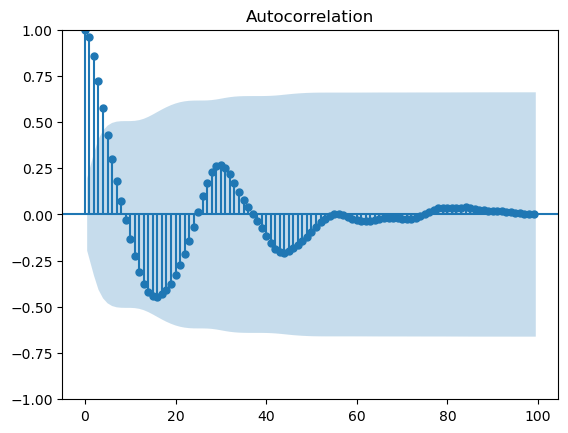

In [14]:
import statsmodels.api as sm

x = maxima_spectrum[3500:3600].copy()
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        y=x
    )
)

# Plot the correlogram
sm.graphics.tsa.plot_acf(x, lags=99)
plt.show()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

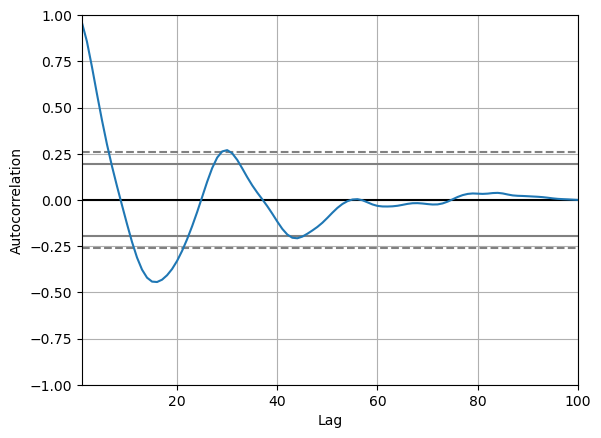

In [15]:
pd.plotting.autocorrelation_plot(x)

In [37]:
def get_autocorrelation(x):
    x = x.copy()
    x -= np.mean(x)
    autocorrelation = np.correlate(x,x,mode='full')
    autocorrelation /= np.var(x)
    return autocorrelation[len(autocorrelation)//2:]

In [69]:
data = np.apply_along_axis(
    func1d=get_autocorrelation,
    axis=1,
    arr=map_data.spectra[:,3500:3600]
)

In [55]:
def get_extremum_locations(x):
    maxima = np.where(np.diff(np.sign(np.diff(x))) == -2)[0] + 1
    minima = np.where(np.diff(np.sign(np.diff(x))) == 2)[0] + 1
    return (maxima, minima)

In [63]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        y=get_autocorrelation(map_data.spectra[0,3500:3600])
        # y=data[0]
    )
)


In [72]:
extremum_locations = [
    get_extremum_locations(x)
    for x
    in data
]

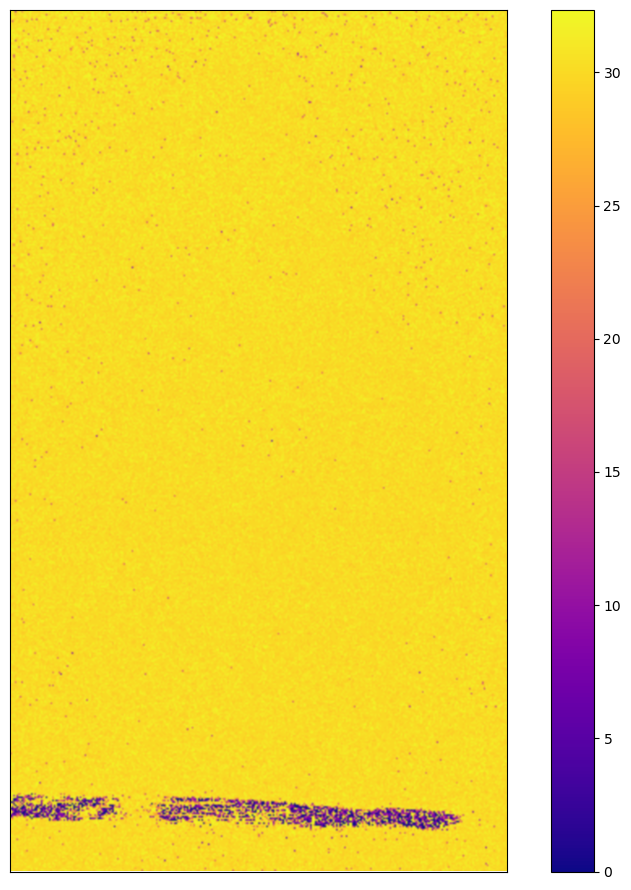

In [80]:
plot_data = np.zeros(len(extremum_locations))
for ndx in range(len(plot_data)):
    try:
        plot_data[ndx] = extremum_locations[ndx][0][0]
    except IndexError:
        pass

plot_single_variable_map(
    map_data.vector_to_array(plot_data),
    fig_size_scaling=3
)

In [29]:
print(np.where(np.diff(np.sign(np.diff(autocorrelation))) == -2)[0] + 1)
print(np.where(np.diff(np.sign(np.diff(autocorrelation))) == 2)[0] + 1)

[30 56 68 79 84]
[16 44 62 71 81]


In [34]:
np.diff(np.where(np.diff(np.sign(np.diff(autocorrelation))) == 2)[0])

array([28, 18,  9, 10], dtype=int64)

In [33]:
autocorrelation[np.where(np.diff(np.sign(np.diff(autocorrelation))) == -2)[0] + 1]
autocorrelation[np.where(np.diff(np.sign(np.diff(autocorrelation))) == 2)[0] + 1]

array([-44.42360715, -20.75078724,  -3.56469943,  -2.4785408 ,
         3.26439593])